In [1]:
# make sure you're logged in with \`huggingface-cli login\`
from diffusers import StableDiffusionParticleSDSPipeline, LMSDiscreteScheduler, DDIMScheduler, DDPMScheduler, SDEScheduler, EulerDiscreteScheduler
import torch
import argparse
import os
from torchvision.utils import make_grid, save_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
# import aesthetic_score
# import open_clip
# import clip

%load_ext autoreload
%autoreload 2

/home/nicolas/anaconda3/envs/stable-dif/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load SD-1.5

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

torch.cuda.set_device(0)

pipe = StableDiffusionParticleSDSPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base")
# pipe = StableDiffusionParticleSDSPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda")

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

# load dino 
dino = torch.hub.load('facebookresearch/dino:main', 'dino_vits16').to("cuda")

# # load clip
# model, _, preprocess = open_clip.create_model_and_transforms('ViT-g-14', pretrained='laion2b_s12b_b42k')
# model2, _ = clip.load("ViT-L/14", device='cuda')  #RN50x64
# model = model.cuda().eval()
# model2 = model2.eval()
# tokenizer = open_clip.get_tokenizer('ViT-g-14')

# # load aesthetic model
# model_aes = aesthetic_score.MLP(768)  # CLIP embedding dim is 768 for CLIP ViT L 14
# s = torch.load("./clip-refs/sac+logos+ava1-l14-linearMSE.pth")   # load the model you trained previously or the model available in this repo
# model_aes.load_state_dict(s)
# model_aes.to("cuda")
# model_aes.eval()

Loading pipeline class <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_particle_SDS.StableDiffusionParticleSDSPipeline'> from /home/nicolas/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1-base/snapshots/5ede9e4bf3e3fd1cb0ef2f7a3fff13ee514fdf06
config_dict {'_class_name': 'StableDiffusionPipeline', '_diffusers_version': '0.10.0.dev0', 'feature_extractor': ['transformers', 'CLIPImageProcessor'], 'requires_safety_checker': False, 'safety_checker': [None, None], 'scheduler': ['diffusers', 'PNDMScheduler'], 'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer'], 'unet': ['diffusers', 'UNet2DConditionModel'], 'vae': ['diffusers', 'AutoencoderKL']}


Using cache found in /home/nicolas/.cache/torch/hub/facebookresearch_dino_main


# Define the prompt

In [3]:
prompt = ["A plate piled high with chocolate chip cookies"]
neg_prompt = ['unrealistic, blurry, low quality, out of focus, ugly, low contrast, dull, dark, low-resolution, gloomy']
num_of_image = 4
prompt = prompt * num_of_image
neg_prompt = neg_prompt * num_of_image

In [6]:

seed = 6
# number of sampling steps
steps = 200
# guidance scale
w = 100.0

torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.random.manual_seed(seed)
# torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

# Vanilla (i.i.d. sampling)

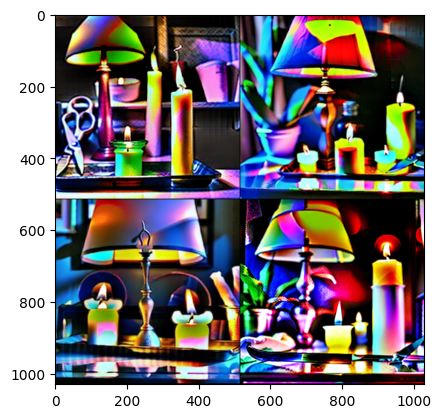

In [5]:
generator = torch.Generator(device="cuda").manual_seed(seed)

out = pipe(prompt, generator=generator, num_inference_steps=steps, guidance_scale=w, output_type='tensor')
image = out.images
image_grid = make_grid(torch.from_numpy(image).permute(0, 3, 1, 2), nrow=int(np.sqrt(len(image))))
plt.imshow(image_grid.permute(1, 2, 0))

del out
torch.cuda.empty_cache()

# Particle Guidance (pixel)

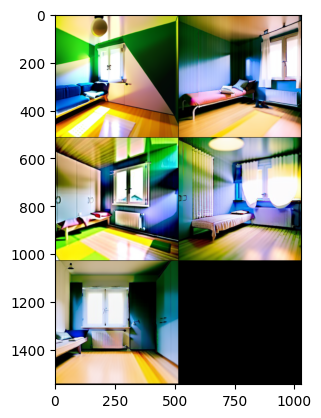

tensor(0.7603, device='cuda:3', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [9]:
generator = torch.Generator(device="cuda").manual_seed(seed)
# coefficient for the particle guidance scale
coeff_list = [0, 100]
# coeff = 30
it = 1
for coeff in coeff_list:   

    out = pipe(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, output_type='tensor')
    images_pixel = out.images
    image_grid = make_grid(torch.from_numpy(images_pixel).permute(0, 3, 1, 2), nrow=int(np.sqrt(len(images_pixel))))
    plt.figure(it)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.show()

    total_pair_wise_sim = 0.
    xo_list = dino(torch.from_numpy(images_pixel).permute(0, 3, 1, 2).cuda())
    # del dino
    xo_list /= xo_list.norm(dim=-1, keepdim=True)
    # calculate the cosine similarity
    sim = (xo_list @ xo_list.T)
    # set the diagonal to be 0
    sim = sim - torch.diag(sim.diag())
    total_pair_wise_sim += sim.sum() / (sim.shape[0] * (sim.shape[0] - 1))
    print(total_pair_wise_sim)

    del out
    torch.cuda.empty_cache()
    it += 1


# Particle Guidance (dino feature space)

In [9]:
generator = torch.Generator(device="cuda").manual_seed(seed)
# coefficient for the particle guidance scale
coeff_list = [900]
# coeff_list = [700, 900]
# lr_list = [0.05, 0.1, 0.4, 0.8]
lr = 0.2 #0.01 for 1000 steps
# coeff = 1000
it = 1
for coeff in coeff_list:   
# for lr in lr_list:
    print(coeff)
    # out = pipe.dino(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, dino=dino, output_type='tensor')
    out = pipe.dino_SDS(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, dino=dino, lr = lr, output_type='tensor') #0.4 for ADAM
    # out = pipe.dino_NFSD(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, dino=dino, lr = lr, output_type='tensor', negative_prompt = neg_prompt)
    images_DINO = out.images
    images_DINO = torch.from_numpy(images_DINO).permute(0, 3, 1, 2)
    image_grid = make_grid(images_DINO)
    plt.figure(it, figsize=(20, 20))
    plt.imshow(image_grid.permute(1, 2, 0))

    total_pair_wise_sim = 0.
    xo_list = dino(images_DINO.cuda())
    # del dino
    xo_list /= xo_list.norm(dim=-1, keepdim=True)
    # calculate the cosine similarity
    sim = (xo_list @ xo_list.T)
    # set the diagonal to be 0
    sim = sim - torch.diag(sim.diag())
    total_pair_wise_sim += sim.sum() / (sim.shape[0] * (sim.shape[0] - 1))
    print(total_pair_wise_sim)

    # torch.save(images_DINO, f'images_DINO_coef{coeff}_buda_.pt')

    del out
    torch.cuda.empty_cache()
    it += 1

900


KeyboardInterrupt: 

In [ ]:
# Compuet Aest score
total_aesthetic_score = 0.

image_features = model2.encode_image(image)
im_emb_arr = aesthetic_score.normalized(image_features.cpu().detach().numpy())
aes_score = model_aes(torch.from_numpy(im_emb_arr).to(image.device).type(torch.cuda.FloatTensor))
total_aesthetic_score += aes_score.sum()

# Particle LPIPS

In [5]:
import lpips

generator = torch.Generator(device="cuda").manual_seed(seed)
# coefficient for the particle guidance scale
coeff_list = [0, 100]
# coeff = 30
it = 1
lpips_ = lpips.LPIPS(net='alex').cuda() # best forward score
for coeff in coeff_list:   

    # out = pipe.dino(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, dino=dino, output_type='tensor')
    out = pipe.lpips_SDS(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, lpips=lpips_, lr=1, output_type='tensor')
    images_DINO = out.images
    image_grid = make_grid(torch.from_numpy(images_DINO).permute(0, 3, 1, 2))
    plt.figure(it, figsize=(20, 20))
    plt.imshow(image_grid.permute(1, 2, 0))

    total_pair_wise_sim = 0.
    xo_list = dino(torch.from_numpy(images_DINO).permute(0, 3, 1, 2).cuda())
    # del dino
    xo_list /= xo_list.norm(dim=-1, keepdim=True)
    # calculate the cosine similarity
    sim = (xo_list @ xo_list.T)
    # set the diagonal to be 0
    sim = sim - torch.diag(sim.diag())
    total_pair_wise_sim += sim.sum() / (sim.shape[0] * (sim.shape[0] - 1))
    print(total_pair_wise_sim)

    del out
    torch.cuda.empty_cache()
    it += 1

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/nicolas/anaconda3/envs/stable-dif/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nicolas/anaconda3/envs/stable-dif/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/nicolas/anaconda3/envs/stable-dif/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


KeyboardInterrupt: 

# COsine simi


In [ ]:
# Cosine similarity 
total_pair_wise_sim = 0.
xo_list = dino(torch.from_numpy(image).permute(0, 3, 1, 2).cuda())
xo_list /= xo_list.norm(dim=-1, keepdim=True)
# calculate the cosine similarity
sim = (xo_list @ xo_list.T)
# set the diagonal to be 0
sim = sim - torch.diag(sim.diag())
total_pair_wise_sim += sim.sum() / (sim.shape[0] * (sim.shape[0] - 1))
print(total_pair_wise_sim)

# # Cosine similarity 
# total_pair_wise_sim = 0.
# xo_list = dino(torch.from_numpy(images_pixel).permute(0, 3, 1, 2).cuda())
# xo_list /= xo_list.norm(dim=-1, keepdim=True)
# # calculate the cosine similarity
# sim = (xo_list @ xo_list.T)
# # set the diagonal to be 0
# sim = sim - torch.diag(sim.diag())
# total_pair_wise_sim += sim.sum() / (sim.shape[0] * (sim.shape[0] - 1))
# print(total_pair_wise_sim)

# # # Cosine similarity 
# total_pair_wise_sim = 0.
# xo_list = dino(torch.from_numpy(images_DINO).permute(0, 3, 1, 2).cuda())
# # del dino
# xo_list /= xo_list.norm(dim=-1, keepdim=True)
# # calculate the cosine similarity
# sim = (xo_list @ xo_list.T)
# # set the diagonal to be 0
# sim = sim - torch.diag(sim.diag())
# total_pair_wise_sim += sim.sum() / (sim.shape[0] * (sim.shape[0] - 1))
# print(total_pair_wise_sim)

In [ ]:
image.shape